### Importing Libraries

In [77]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
%matplotlib inline

### Reading csv data using Pandas

In [78]:
data = pd.read_csv(r'G:\Tweets.csv')

In [79]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### EDA of the data

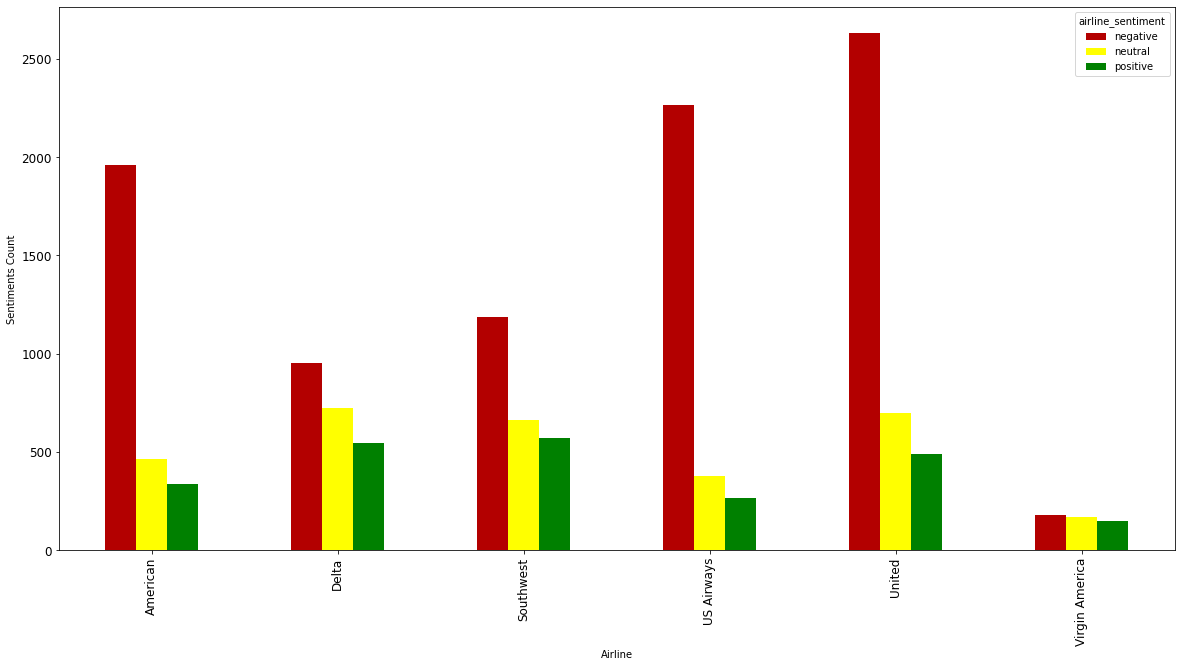

In [80]:
sentiment_plot = data.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack().plot(kind = 'bar', figsize = (20, 10), fontsize = 12.0, xlabel = ('Airline'), ylabel = 'Sentiments Count', color=['#b30000', 'yellow', 'green'])

### Segregation of features and target of data

In [81]:
features = data.iloc[:,10]
target = data.iloc[:,1]

### Removing unnecessary characters and stopwords from tweets

In [82]:
processed_features = []
for sentence in range(0, len(features)):
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    #remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    #remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    #Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    #removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)
    
    #ronverting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)
    



In [83]:
corpus = []
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
for sentence in processed_features:
    sentence = sentence.lower()
    words = sentence.split(" ")
    
    filtered_words = [word.lower() for word in words if not word in stopwords]
    corpus.append(" ".join(filtered_words))
    


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Importing TfidfVectorizer

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1700, min_df=10, max_df=0.75)
processed_features = vectorizer.fit_transform(corpus).toarray()
processed_features.shape

(14640, 1700)

### Splitting data into train and test data set

In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, target, test_size=0.20, random_state=0)

### Using Logistic Regression classifier for analysis

In [86]:
from sklearn.linear_model import LogisticRegression
text_classifier = LogisticRegression(random_state = 0, max_iter = 200, solver = 'lbfgs', verbose = True)

text_classifier.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s finished


LogisticRegression(max_iter=200, random_state=0, verbose=True)

### Using test dataset for predictions

In [87]:
predictions = text_classifier.predict(X_test)

### Result

In [88]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print(confusion_matrix(y_test, predictions))

print(classification_report(y_test, predictions))

print(accuracy_score(y_test, predictions))

[[1733  110   27]
 [ 263  310   41]
 [ 119   61  264]]
              precision    recall  f1-score   support

    negative       0.82      0.93      0.87      1870
     neutral       0.64      0.50      0.57       614
    positive       0.80      0.59      0.68       444

    accuracy                           0.79      2928
   macro avg       0.75      0.68      0.71      2928
weighted avg       0.78      0.79      0.78      2928

0.7879098360655737


### Using deep learning methods to create a model

In [89]:
import tensorflow as tf
tf.__version__

'2.0.0'

### Importing libraries

In [90]:
from tensorflow import keras
from tensorflow.keras import layers

In [91]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Embedding

### Introducing dummies, tokenizer and splitting the dataset

In [105]:
ycat=pd.get_dummies(target).values
X=features.values
tk = Tokenizer()
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X_pad, ycat, test_size = 0.20, random_state = 0)

### Adding layers to the model

In [106]:
vocabulary_size = len(tk.word_counts.keys())+1
max_words = 100
embedding_size = 32
model = Sequential()
model.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 32)           504608    
_________________________________________________________________
flatten_14 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 9603      
Total params: 514,211
Trainable params: 514,211
Non-trainable params: 0
_________________________________________________________________


### Fitting the model with datatset

In [107]:
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=32,epochs=3,verbose=True)

Train on 11712 samples, validate on 2928 samples
Epoch 1/3
11712/11712 [==============================] - 9s 794us/sample - loss: 0.7342 - accuracy: 0.6946 - val_loss: 0.5937 - val_accuracy: 0.7695
Epoch 2/3
11712/11712 [==============================] - 9s 779us/sample - loss: 0.4621 - accuracy: 0.8262 - val_loss: 0.5093 - val_accuracy: 0.8046
Epoch 3/3
11712/11712 [==============================] - 9s 801us/sample - loss: 0.3171 - accuracy: 0.8913 - val_loss: 0.5079 - val_accuracy: 0.8060


### Using the test dataset to make predictions

In [108]:
predictions = [np.argmax(i) for i in model.predict(X_test)]
y_test=[np.argmax(i) for i in y_test]

print(confusion_matrix(y_test, predictions))

print(classification_report(y_test,predictions,target_names=['negative','neutral','positive'])),

print(accuracy_score(y_test, predictions))




[[1711  120   39]
 [ 218  346   50]
 [  93   48  303]]
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      1870
     neutral       0.67      0.56      0.61       614
    positive       0.77      0.68      0.72       444

    accuracy                           0.81      2928
   macro avg       0.76      0.72      0.74      2928
weighted avg       0.80      0.81      0.80      2928

0.8060109289617486
